# Orbisage — Full Demo Notebook
This notebook walks through installing dependencies, building the Orbisage router graph, visualising it, and launching two Gradio chat UIs:
1. **Inline UI** (runs inside the notebook)
2. **External UI** (listens on `0.0.0.0:7860` for Docker/K8s)


## 1. Install Dependencies
Run this cell if you haven't installed the package yet.

In [1]:
# !pip install -q langgraph langchain-openai langchain-community  gradio ipykernel newsapi-python requests

## 2. Import and Visualise Graph

In [2]:
%load_ext autoreload
%autoreload 2

import os, sys, pathlib, openai, gradio as gr
# put your project root on the path
try:
    project_root = pathlib.Path(__file__).resolve().parents[2]
except NameError:
    project_root = pathlib.Path.cwd().resolve().parents[1]
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

# this ensures notebook always picks up your edited agent.py
import orbisage_router.agent as _agent_mod
import importlib
importlib.reload(_agent_mod)

from orbisage_router.agent import OrbiAgent
agent = OrbiAgent()

print("✅ Using OrbiAgent from:", _agent_mod.__file__)

✅ Using OrbiAgent from: /Users/mulugetasemework/Library/Mobile Documents/com~apple~CloudDocs/dropback/Phyton/LLM/orbi/orbisage_router/agent.py


In [4]:
print("Agent ready!  Try:", agent.run("tell me a joke"))

Agent ready!  Try: Programming is 10% science, 20% ingenuity, and 70% getting the ingenuity to work with the science.


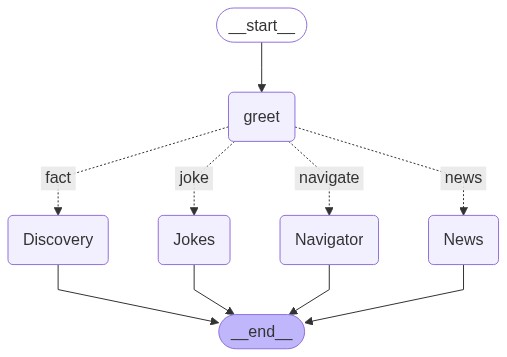

✅ OPENAI_API_KEY loaded.


In [5]:
# ─── Optional: display the router graph for reference ───────────────────
from orbisage_router.graph import build_router_graph
from IPython.display import Image, display

wf = build_router_graph()
display(Image(wf.get_graph().draw_mermaid_png()))

# ─── Check agent is ready ────────────────────────────────────────────────
openai.api_key = os.getenv("OPENAI_API_KEY", "")
if not openai.api_key:
    print("⚠️ OPENAI_API_KEY not set – using local logic only.")
else:
    print("✅ OPENAI_API_KEY loaded.")

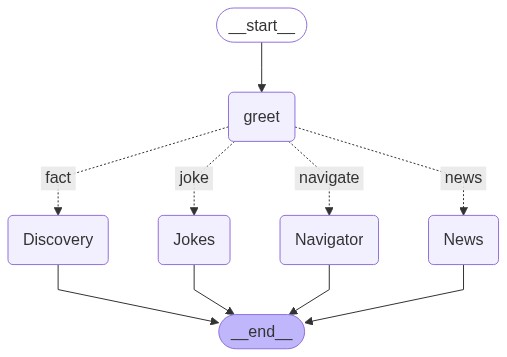

✅ Router graph saved as: orbisage_router_graph.png
✅ OPENAI_API_KEY loaded.


In [23]:
from orbisage_router.graph import build_router_graph
from IPython.display import Image, display

# Build the workflow
wf = build_router_graph()

# Correct: get the PNG bytes
png_bytes = wf.get_graph().draw_mermaid_png()

# Save manually
graph_png_path = "orbisage_router_graph.png"
with open(graph_png_path, "wb") as f:
    f.write(png_bytes)

# Display the saved image inline
display(Image(graph_png_path))

print(f"✅ Router graph saved as: {graph_png_path}")

# ─── Check agent is ready ────────────────────────────────────────────────
import openai, os

openai.api_key = os.getenv("OPENAI_API_KEY", "")
if not openai.api_key:
    print("⚠️ OPENAI_API_KEY not set – using local logic only.")
else:
    print("✅ OPENAI_API_KEY loaded.")


In [6]:
print(agent.run("tell me a joke"))

Have a great weekend!
I hope your code behaves the same on Monday as it did on Friday.


In [7]:
print(agent.run("tell me a joke"))

A guy walks into a bar and asks for 1.4 root beers.
The bartender says "I'll have to charge you extra, that's a root beer float".
The guy says "In that case, better make it a double."


In [8]:
print(agent.run("tell me how to get into the cafeteria?"))

I can only navigate between Entrance, Office, Gym, Bathroom, Cafeteria, and Doctor's Office. Try 'from office to gym'.


In [9]:
print(agent.run("what are the three big news today?"))

The football world is in shock over the death of Liverpool forward Diogo Jota in a car crash at the age of 28. Meanwhile, a Gaza aid contractor has accused colleagues of firing on hungry Palestinians, a claim strongly denied by the foundation. Additionally, the sale of illegal cigarettes in British high streets highlights a deeper issue with the trade containing harmful substances like human excrement and asbestos.


## 3. Inline Gradio Chat

In [20]:
# Make sure chat_inline is defined as before:
def chat_inline(msg, history):
    history = history or []
    history.append({"role": "user", "content": msg})
    response = agent.run(msg)
    history.append({"role": "assistant", "content": response})
    return "", history

with gr.Blocks() as inline_demo:
    gr.Markdown("### Orbisage – Inline Chat in Notebook")

    # Initialize an empty chat history and constrain the height
    chatbot = gr.Chatbot(value=[], type="messages", height=200)

    with gr.Row():
        txt     = gr.Textbox(
            show_label=False,
            placeholder="Ask me anything…",
            lines=1,
            max_lines=5
        )
        send_btn = gr.Button("Submit")

    # Bind both Enter and the Send button
    txt.submit(chat_inline, inputs=[txt, chatbot], outputs=[txt, chatbot])
    send_btn.click(chat_inline, inputs=[txt, chatbot], outputs=[txt, chatbot])

inline_demo.launch(inline=True, share=False)


* Running on local URL:  http://127.0.0.1:7870
* To create a public link, set `share=True` in `launch()`.


## 4. External Gradio Chat (Docker/K8s)

In [16]:
import socket

def find_free_port(start=7860, end=7900, host="0.0.0.0"):
    for port in range(start, end + 1):
        with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
            try:
                s.bind((host, port))
                return port
            except OSError:
                continue
    raise OSError(f"No free ports in range {start}-{end}")


In [21]:
# External chat UI
def chat_external(msg, history):
    history = history or []
    history.append({"role": "user", "content": msg})
    response = agent.run(msg)
    history.append({"role": "assistant", "content": response})
    return "", history

with gr.Blocks() as ext_demo:
    gr.Markdown("### Orbisage – External Chat on 0.0.0.0:7860")
    
    # Constrain the chat window height and start with empty messages
    chatbot2 = gr.Chatbot(value=[], type="messages", height=300)
    
    with gr.Row():
        txt2     = gr.Textbox(
            show_label=False,
            placeholder="Ask me anything…",
            lines=1,
            max_lines=5
        )
        send_btn2 = gr.Button("Send")
    
    # Bind both Enter and the Send button to the same callback
    txt2.submit(chat_external, inputs=[txt2, chatbot2], outputs=[txt2, chatbot2])
    send_btn2.click(chat_external, inputs=[txt2, chatbot2], outputs=[txt2, chatbot2])
    
    # Clear input after submission
    txt2.submit(lambda: "", None, txt2)

# Auto-recover from port busy as before
desired_port = 7860
try:
    ext_demo.launch(server_name="0.0.0.0", server_port=desired_port, share=False)
except OSError:
    fallback = find_free_port(start=desired_port+1, end=7900)
    print(f"[i] Port 7860 busy, switching to {fallback}")
    ext_demo.launch(server_name="0.0.0.0", server_port=fallback, share=False)


[i] Port 7860 busy, switching to 7871
* Running on local URL:  http://0.0.0.0:7871
* To create a public link, set `share=True` in `launch()`.
